In [2]:
import os, glob
import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import myutil.myutil as util

from evo.core import metrics
import evo.core.sync as sync
import evo.core.trajectory as evotraj

# Time to start considering the estimate
test_start = 2.5
test_end = np.inf

log_path = '/media/tmn/mySataSSD1/Experiments/gptr/logs/lio/cathhs_07/'
gtr_path = '/media/tmn/mySataSSD1/Experiments/gptr/cathhs_07/gtr/'

# The path to the experiment log
xtrz_log = '/media/tmn/mySataSSD1/Experiments/gptr/logs/lio/cathhs_exp/cathhs_07_gptr_two_lidar/run_00/time_0033/extrinsics_1.csv'

# The path to the trajectories
traj_est_logs = ['/media/tmn/mySataSSD1/Experiments/gptr/logs/lio/cathhs_exp/cathhs_07_gptr_two_lidar/run_00/time_0033/gptraj_0.csv',
                 '/media/tmn/mySataSSD1/Experiments/gptr/logs/lio/cathhs_exp/cathhs_07_gptr_two_lidar/run_00/time_0033/gptraj_1.csv']

traj_est1lidar_logs = ['/media/tmn/mySataSSD1/Experiments/gptr/logs/lio/cathhs_exp/cathhs_07_gptr_lidar0/run_00/time_0033/gptraj_0.csv',
                       '/media/tmn/mySataSSD1/Experiments/gptr/logs/lio/cathhs_exp/cathhs_07_gptr_lidar1/run_00/time_0033/gptraj_0.csv']

traj_estkf_logs = [log_path + '/kf_exp/lidar_0_pose.pcd',
                   log_path + '/kf_exp/lidar_1_pose.pcd']

traj_trajlo_logs = [log_path + '/trajlo_exp/cathhs_lidar0_estimated_pose.txt',
                    log_path + '/trajlo_exp/cathhs_lidar1_estimated_pose.txt']

# Trajectory groundtruth error
traj_gtr_logs = [gtr_path + '/lidar_0_gtr.txt',
                 gtr_path + '/lidar_1_gtr.txt']

# Lidar extrinsic
pose_B_L = [np.array([ 0,    0,  0,  0,    0,  0]),
            np.array([ 0,    90, 0,  0.117, 0, -0.141])]
T_B_L = []
for pose in pose_B_L:
	T = np.identity(4)
	T[0:3, 0:3] = util.eul2rotm(pose[0]/180*np.pi, pose[1]/180*np.pi, pose[2]/180*np.pi)
	T[0:3, 3] = pose[3:].T
	T_B_L.append(T)
	print("quat_B_L", util.rotm2quat(T[0:3, 0:3]))

T_L0_L1 = util.tfmult(util.tfinv(T_B_L[0]), T_B_L[1])
Rot01 = T_L0_L1[0:3, 0:3]
Pos01 = T_L0_L1[0:3, 3]
Eul01 = np.array(util.rotm2eul(Rot01))/math.pi*180
Qua01 = np.array(util.rotm2quat(Rot01))
print("xyz", Pos01)
print("ypr", Eul01)


RAD2DEG = 180/np.pi

# # Lidar extrinsic slip
# pose_B_L_slip = [np.array([0,  45, 0,  0,   0,  0]),
#                  np.array([180, 0, 0, -0.5, 0, -0.35])]
# T_B_L_slip = []
# for pose in pose_B_L_slip:
# 	T_slip = np.identity(4)
# 	T_slip[0:3, 0:3] = util.eul2rotm(pose[0]/180*np.pi, pose[1]/180*np.pi, pose[2]/180*np.pi)
# 	T_slip[0:3, 3] = pose[3:].T
# 	T_B_L_slip.append(T_slip)

# T_L0_L1_slip = util.tfmult(util.tfinv(T_B_L_slip[0]), T_B_L_slip[1])
# Rot01_slip = T_L0_L1_slip[0:3, 0:3]
# Pos01_slip = T_L0_L1_slip[0:3, 3]
# Eul01_slip = np.array(util.rotm2eul(Rot01_slip))/math.pi*180
# Qua01_slip = np.array(util.rotm2quat(Rot01_slip))
# print("xyz", Pos01_slip)
# print("ypr", Eul01_slip)


# pose_W_L = [np.array([ 43,  48, 0,  0,    0,   0.70]),
#             np.array([-134, 0,  0, -0.3, -0.3, 0.55])]
# T_W_L = []
# for pose in pose_W_L:
# 	T = np.identity(4)
# 	T[0:3, 0:3] = util.eul2rotm(pose[0]/180*np.pi, pose[1]/180*np.pi, pose[2]/180*np.pi)
# 	T[0:3, 3] = pose[3:].T
# 	T_W_L.append(T)
# T_L0_L1_init = util.tfmult(util.tfinv(T_W_L[0]), T_W_L[1])
# Rot01_init = T_L0_L1_init[0:3, 0:3]
# Pos01_init = T_L0_L1_init[0:3, 3]
# Eul01_init = np.array(util.rotm2eul(Rot01_init))/math.pi*180
# Qua01_init = np.array(util.rotm2quat(Rot01_init))
# print("xyz_init", Pos01_init)
# print("ypr_init", Eul01_init)

# print("xyz_init_error", Pos01_init - Pos01)
# print("ypr_init_error", Eul01_init - Eul01)

quat_B_L [1. 0. 0. 0.]
quat_B_L [0.70710678 0.         0.70710678 0.        ]
xyz [ 0.117  0.    -0.141]
ypr [ 0. 90. -0.]


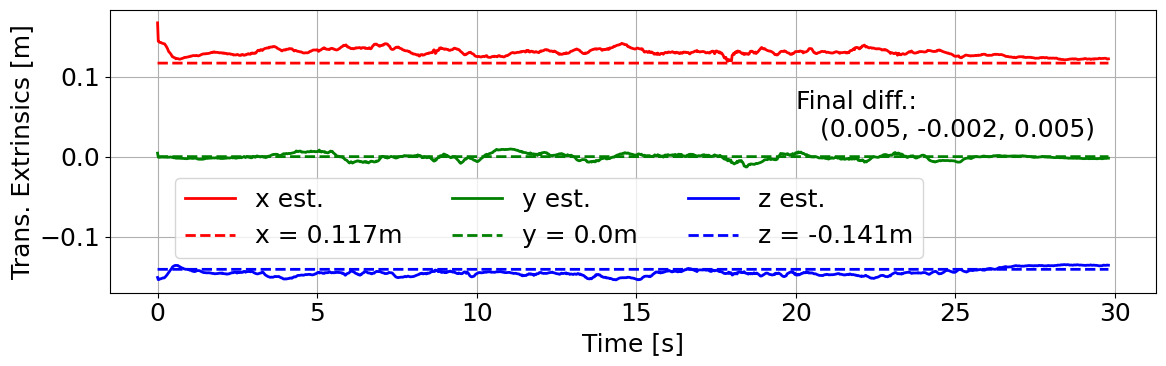

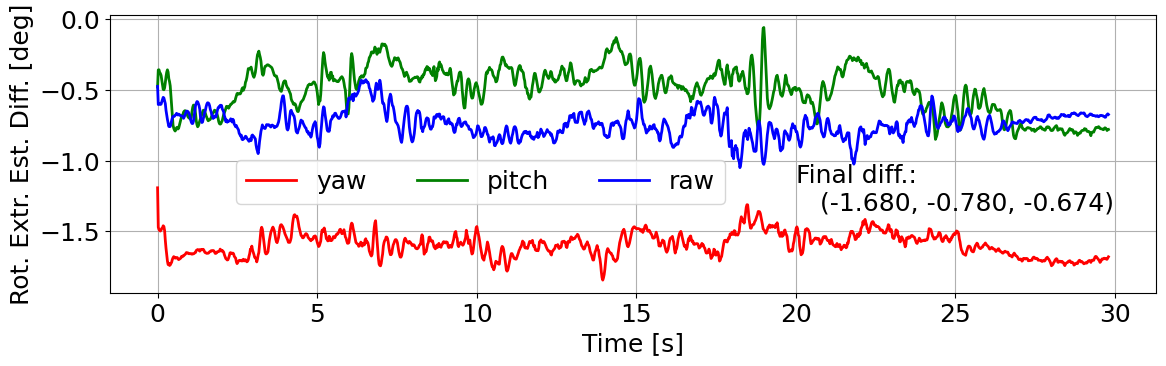

In [3]:
# Load the extrinsic data
xtrz_data = np.loadtxt(xtrz_log, delimiter=',', skiprows=1)
txtrz = xtrz_data[:, 0] - xtrz_data[0, 0]

# Calculate the position data
p_L0_L1_est = xtrz_data[:, 1:4]
p_L0_L1_err = np.zeros(p_L0_L1_est.shape)
p_L0_L1_gtr = np.zeros(p_L0_L1_est.shape)
for idx, t in enumerate(txtrz):
        p_L0_L1_err[idx, :] = p_L0_L1_est[idx, :] - Pos01
        p_L0_L1_gtr[idx, :] = Pos01

# Calculate the oritation error
Q_L0_L1_est = []
E_L0_L1_est = []
E_L0_L1_err = []
for idx, t in enumerate(txtrz):
    q = xtrz_data[idx, [7, 4, 5, 6]]
    Q_L0_L1_est.append(util.quat2rotm(q))
    E_L0_L1_est.append(list(util.quat2eul(q)))
    E_L0_L1_err.append(list(util.rotm2eul(Q_L0_L1_est[-1].transpose()@Rot01)))

E_L0_L1_est = np.array(E_L0_L1_est).reshape((-1, 3))
E_L0_L1_err = np.array(E_L0_L1_err).reshape((-1, 3))

# Plot the error
plt.rcParams.update({'font.size':18})
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 4))

ax.plot(txtrz, p_L0_L1_est[:, 0], linewidth=2, color='r', label='x est.')
ax.plot(txtrz, p_L0_L1_gtr[:, 0], linewidth=2, color='r', label=f'x = {p_L0_L1_gtr[0, 0]}m', linestyle='--')

ax.plot(txtrz, p_L0_L1_est[:, 1], linewidth=2, color='g', label='y est.')
ax.plot(txtrz, p_L0_L1_gtr[:, 1], linewidth=2, color='g', label=f'y = {p_L0_L1_gtr[0, 1]}m', linestyle='--')

ax.plot(txtrz, p_L0_L1_est[:, 2], linewidth=2, color='b', label='z est.')
ax.plot(txtrz, p_L0_L1_gtr[:, 2], linewidth=2, color='b', label=f'z = {p_L0_L1_gtr[0, 2]}m', linestyle='--')

ax.text(s=f'Final diff.: \n   ({p_L0_L1_err[-1, 0]:.3f}, {p_L0_L1_err[-1, 1]:.3f}, {p_L0_L1_err[-1, 2]:.3f})', x=20, y=0.025)

# ax.set_xlim([5, 15])
ax.grid('on')
ax.legend(ncol=3, loc='upper left', bbox_to_anchor=(0.05, 0.45))

ax.set_xlabel('Time [s]')
ax.set_ylabel('Trans. Extrinsics [m]')
plt.tight_layout()
fig.savefig('cathhs_trans_extrinsics_error.jpg')

# Plot the error
plt.rcParams.update({'font.size':18})
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 4))

ax.plot(txtrz, E_L0_L1_err[:, 0]*RAD2DEG, linewidth=2, color='r', label='yaw')
ax.plot(txtrz, E_L0_L1_err[:, 1]*RAD2DEG, linewidth=2, color='g', label='pitch')
ax.plot(txtrz, E_L0_L1_err[:, 2]*RAD2DEG, linewidth=2, color='b', label='raw')

ax.text(s=f'Final diff.: \n   ({E_L0_L1_err[-1, 0]*RAD2DEG:.3f}, {E_L0_L1_err[-1, 1]*RAD2DEG:.3f}, {E_L0_L1_err[-1, 2]*RAD2DEG:.3f})', x=20, y=-1.35)

ax.grid('on')
ax.legend(ncol=3, bbox_to_anchor=(0.6, 0.4))

ax.set_xlabel('Time [s]')
ax.set_ylabel('Rot. Extr. Est. Diff. [deg]')

plt.tight_layout()
fig.savefig('cathhs_rot_extrinsics_error.jpg')


-0.0005531568201527365 -0.011704344840100425 -0.648482580524448 177.38359202279256 -0.8245152890627347 -0.4379898763918161
0.0060884955126389185 -0.004330908712316635 -0.6651408904403251 177.87202565364882 -0.8172741800829122 -0.38683586814255466


/tmp/ipykernel_907709/3471181934.py:76: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(est[:, 0], est[:, 1], est[:, 2], 'b-', linestyle='--', linewidth=3*(lidx + 1), label=f'GPTR Estimate Lidar {lidx}')
/tmp/ipykernel_907709/3471181934.py:77: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(gtr[:, 0], gtr[:, 1], gtr[:, 2], 'r-', linestyle='--', linewidth=2*(lidx + 1), label='Ground Truth')


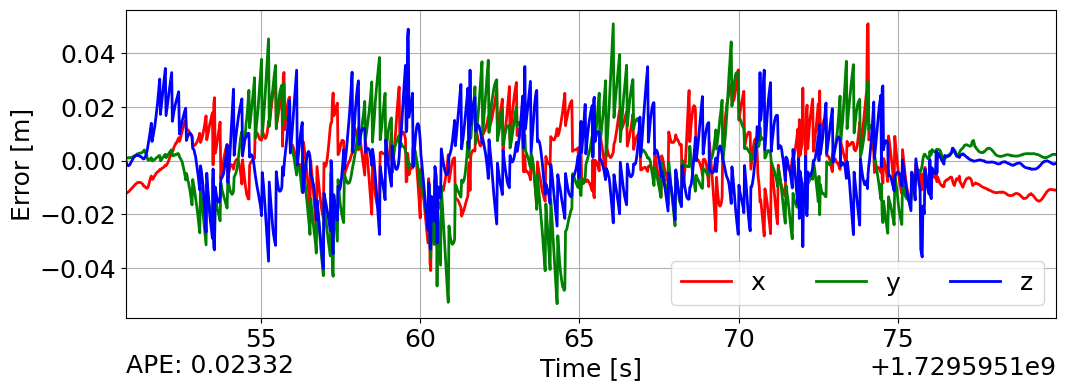

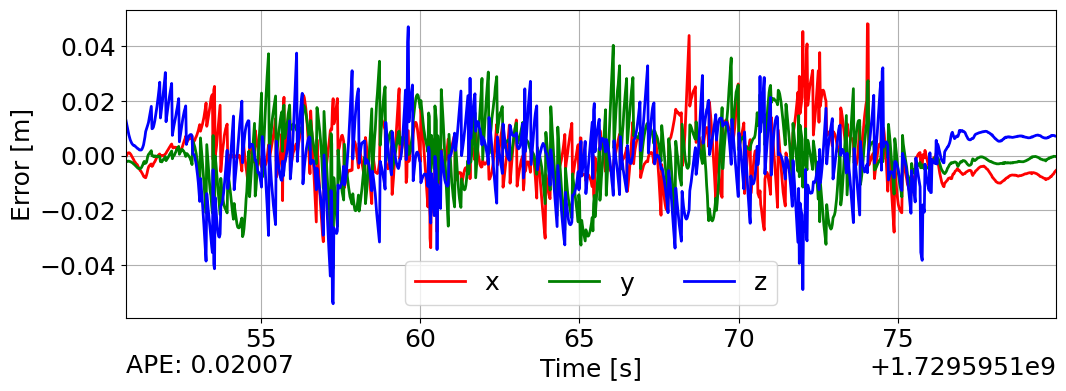

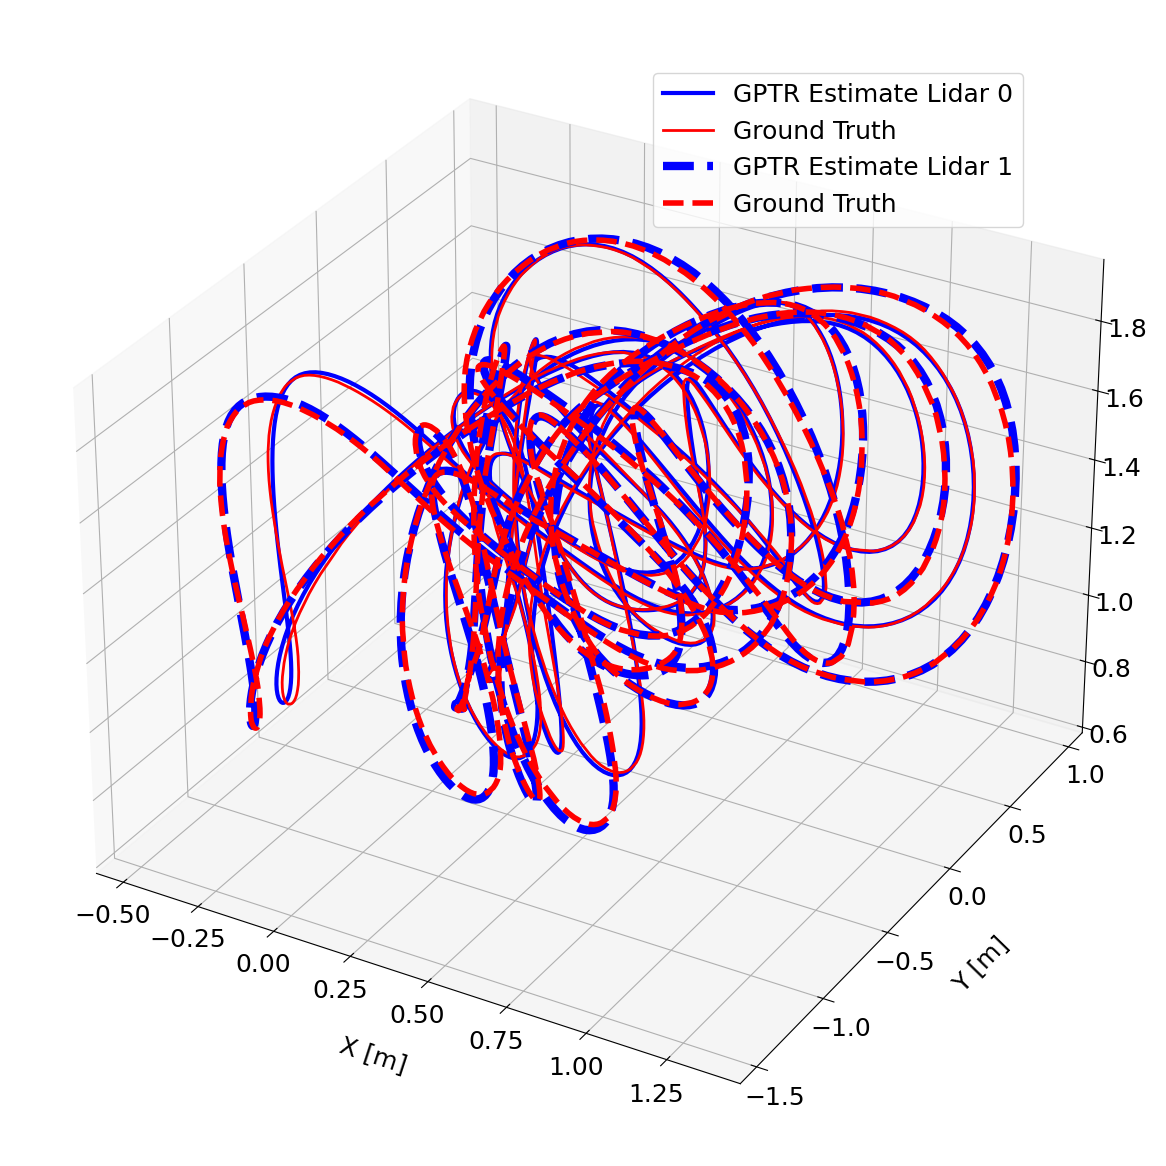

In [4]:
# Calculate the ATE
def calculate_metric(traj_gtr, traj_est):
    metric = metrics.APE(pose_relation=metrics.PoseRelation.translation_part)
    metric.process_data((traj_gtr, traj_est))
    return float(metric.get_result(ref_name='reference', est_name='estimate').stats['rmse'])

# Load the trajectory
traj_est_data = []
for log in traj_est_logs:
    traj_est_data.append(np.loadtxt(log, delimiter=',', skiprows=1))

traj_gtr_data = []
for log in traj_gtr_logs:
    traj_gtr_data.append(np.loadtxt(log, delimiter=' '))

lidar_est = []
lidar_gtr = []

for lidx in range(len(traj_est_data)):

    # Get the traj_est
    traj_est = traj_est_data[lidx]
    test = (traj_est[:, 1] - traj_est[0, 1]).reshape(-1, 1)
    tidx = list(np.where((test_start < test) & (test < test_end))[0])
    traj_est = evotraj.PoseTrajectory3D(positions_xyz=traj_est[tidx, :][:, [12, 13, 14]], orientations_quat_wxyz=traj_est[tidx, :][:, [5, 2, 3, 4]], timestamps=traj_est[tidx, 1])

    # Get the traj gtr
    traj_gtr = traj_gtr_data[lidx]
    traj_gtr = evotraj.PoseTrajectory3D(positions_xyz=traj_gtr[:, 2:5], orientations_quat_wxyz=traj_gtr[:, [8, 5, 6, 7]], timestamps=traj_gtr[:, 1])

    traj_est, traj_gtr = sync.associate_trajectories(traj_est, traj_gtr, max_diff=0.2)
    T_G_E = traj_est.align(traj_gtr)
    traj_err = evotraj.PoseTrajectory3D(positions_xyz=traj_est.positions_xyz - traj_gtr.positions_xyz, \
                                        orientations_quat_wxyz=traj_est.orientations_quat_wxyz, timestamps=traj_est.timestamps)

    # Find the RMSE
    rmse = calculate_metric(traj_est, traj_gtr)

    plt.rcParams.update({'font.size':18})
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 4))
    ax.plot(traj_err.timestamps, traj_err.positions_xyz[:, 0], 'r', linewidth=2, label='x')
    ax.plot(traj_err.timestamps, traj_err.positions_xyz[:, 1], 'g', linewidth=2, label='y')
    ax.plot(traj_err.timestamps, traj_err.positions_xyz[:, 2], 'b', linewidth=2, label='z')

    # Stamp the ATE
    ax.text(0, -0.18, f'APE: {rmse:.5f}', transform=ax.transAxes)

    ax.set_xlim([np.min(traj_est.timestamps), np.max(traj_est.timestamps-1.0)])
    # ax.set_ylim([-0.06, 0.06])
    ax.legend(ncols=3)
    ax.grid('on')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Error [m]')

    lidar_est.append(traj_est.positions_xyz)
    lidar_gtr.append(traj_gtr.positions_xyz)

    R_G_E = T_G_E[0].reshape((3, 3))
    P_G_E = T_G_E[1].reshape((3, 1))

    E_E_G =  (np.array(util.rotm2eul(R_G_E.T)).reshape((1, 3))/np.pi*180)[0]
    P_E_G =  (-R_G_E.T@P_G_E).T[0]

    print(P_E_G[0], P_E_G[1], P_E_G[2], E_E_G[0], E_E_G[1], E_E_G[2],)


plt.rcParams.update({'font.size':18})
fig = plt.figure(figsize=(15, 12), edgecolor='black')
ax = fig.add_subplot(111, projection='3d')
for lidx, est in enumerate(lidar_est):
    gtr = lidar_gtr[lidx]
    if lidx == 0:
        ax.plot(est[:, 0], est[:, 1], est[:, 2], 'b', linewidth=3*(lidx + 1), label=f'GPTR Estimate Lidar {lidx}')
        ax.plot(gtr[:, 0], gtr[:, 1], gtr[:, 2], 'r', linewidth=2*(lidx + 1), label='Ground Truth')
    else:
        ax.plot(est[:, 0], est[:, 1], est[:, 2], 'b-', linestyle='--', linewidth=3*(lidx + 1), label=f'GPTR Estimate Lidar {lidx}')
        ax.plot(gtr[:, 0], gtr[:, 1], gtr[:, 2], 'r-', linestyle='--', linewidth=2*(lidx + 1), label='Ground Truth')

ax.set_xlabel('X [m]', labelpad=20)
ax.set_ylabel('Y [m]', labelpad=20)
ax.set_zlabel('Z [m]', labelpad=20)

plt.subplots_adjust(left=0.1, right=1.0, top=0.9, bottom=0.1)  # Increase space around the plot

ax.legend(ncol=1, bbox_to_anchor=(0.55, 0.8))
plt.tight_layout()
fig.savefig(f'lidar_est_vs_gtr.jpg')


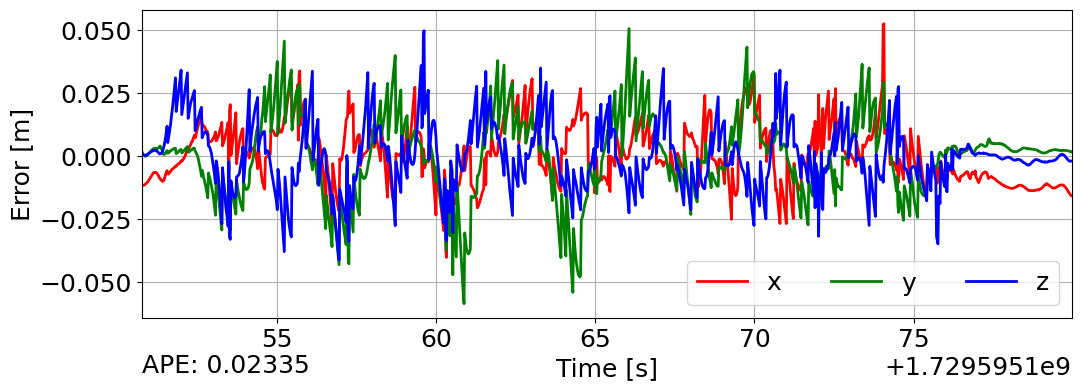

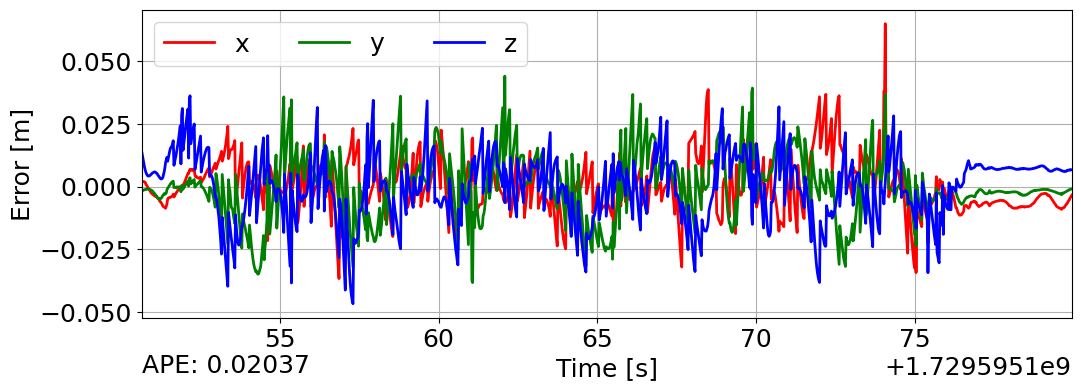

In [5]:
# Load the trajectory
traj_est1lidar_data = []
for log in traj_est1lidar_logs:
    traj_est1lidar_data.append(np.loadtxt(log, delimiter=',', skiprows=1))

traj_gtr_data = []
for log in traj_gtr_logs:
    traj_gtr_data.append(np.loadtxt(log, delimiter=' '))

for lidx in range(len(traj_est1lidar_data)):

    # Get the traj_est
    traj_est1lidar = traj_est1lidar_data[lidx]
    test1lidar = (traj_est1lidar[:, 1] - traj_est1lidar[0, 1]).reshape(-1, 1)
    tidx = list(np.where((test_start < test1lidar) & (test1lidar < test_end))[0])
    traj_est1lidar = evotraj.PoseTrajectory3D(positions_xyz=traj_est1lidar[tidx, :][:, [12, 13, 14]], orientations_quat_wxyz=traj_est1lidar[tidx, :][:, [5, 2, 3, 4]], timestamps=traj_est1lidar[tidx, 1])

    # Get the traj gtr
    traj_gtr = traj_gtr_data[lidx]
    traj_gtr = evotraj.PoseTrajectory3D(positions_xyz=traj_gtr[:, 2:5], orientations_quat_wxyz=traj_gtr[:, [8, 5, 6, 7]], timestamps=traj_gtr[:, 1])

    traj_est1lidar, traj_gtr = sync.associate_trajectories(traj_est1lidar, traj_gtr, max_diff=0.2)
    traj_est1lidar.align(traj_gtr)
    traj_err = evotraj.PoseTrajectory3D(positions_xyz=traj_est1lidar.positions_xyz - traj_gtr.positions_xyz, \
                                        orientations_quat_wxyz=traj_est1lidar.orientations_quat_wxyz, timestamps=traj_est1lidar.timestamps)

    # Find the RMSE
    rmse = calculate_metric(traj_est1lidar, traj_gtr)

    plt.rcParams.update({'font.size':18})
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 4))
    ax.plot(traj_err.timestamps, traj_err.positions_xyz[:, 0], 'r', linewidth=2, label='x')
    ax.plot(traj_err.timestamps, traj_err.positions_xyz[:, 1], 'g', linewidth=2, label='y')
    ax.plot(traj_err.timestamps, traj_err.positions_xyz[:, 2], 'b', linewidth=2, label='z')

    # Stamp the ATE
    ax.text(0, -0.18, f'APE: {rmse:.5f}', transform=ax.transAxes)

    ax.set_xlim([np.min(traj_est1lidar.timestamps), np.max(traj_est1lidar.timestamps-1.0)])
    # ax.set_ylim([-0.06, 0.06])
    ax.legend(ncols=3)
    ax.grid('on')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Error [m]')



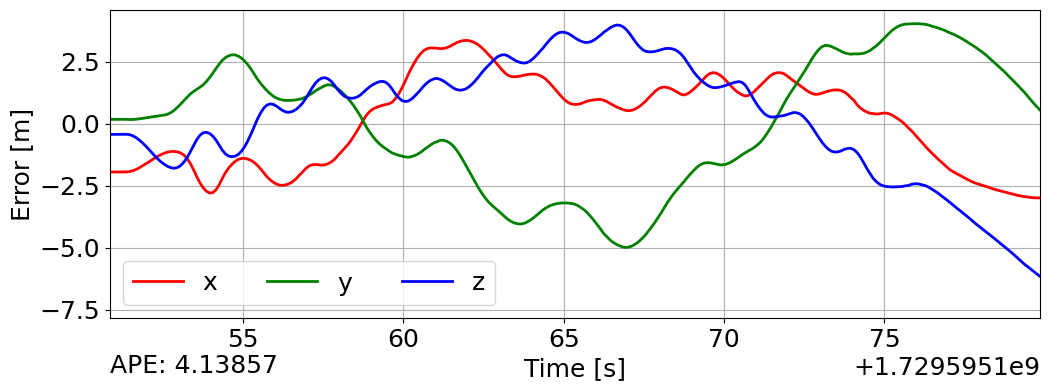

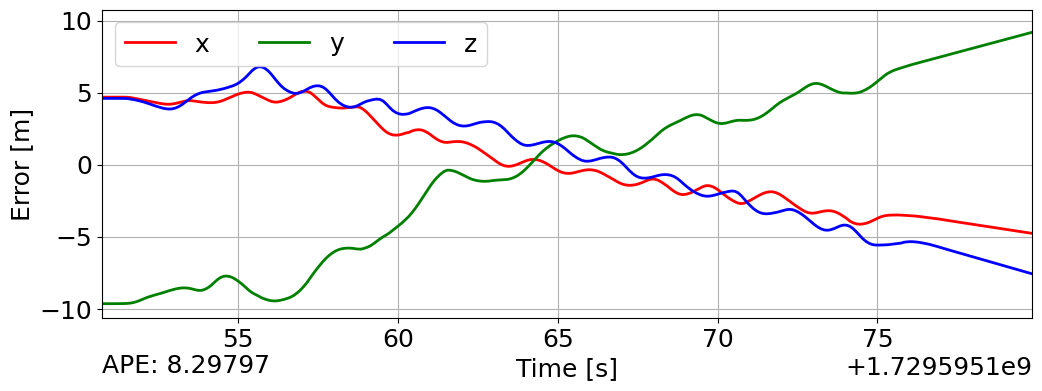

In [6]:
# Load the trajectory
traj_estkf_data = []
for log in traj_estkf_logs:
    traj_estkf_data.append(np.loadtxt(log, delimiter=' ', skiprows=11))

traj_gtr_data = []
for log in traj_gtr_logs:
    traj_gtr_data.append(np.loadtxt(log, delimiter=' '))

for lidx in range(len(traj_estkf_data)):

    # Get the traj_estkf
    traj_estkf = traj_estkf_data[lidx]
    testkf = (traj_estkf[:, 4] - traj_estkf[0, 4]).reshape(-1, 1)
    tidx = list(np.where( (test_start < testkf) & (testkf < test_end) )[0])
    traj_estkf = evotraj.PoseTrajectory3D(positions_xyz=traj_estkf[tidx, :][:, [0, 1, 2]], orientations_quat_wxyz=traj_estkf[tidx, :][:, [8, 5, 6, 7]], timestamps=traj_estkf[tidx, 4])

    # Get the traj gtr
    traj_gtr = traj_gtr_data[lidx]
    traj_gtr = evotraj.PoseTrajectory3D(positions_xyz=traj_gtr[:, 2:5], orientations_quat_wxyz=traj_gtr[:, [8, 5, 6, 7]], timestamps=traj_gtr[:, 1])

    traj_estkf, traj_gtr = sync.associate_trajectories(traj_estkf, traj_gtr, max_diff=0.2)
    traj_estkf.align(traj_gtr)
    traj_err = evotraj.PoseTrajectory3D(positions_xyz=traj_estkf.positions_xyz - traj_gtr.positions_xyz, \
                                        orientations_quat_wxyz=traj_estkf.orientations_quat_wxyz, timestamps=traj_estkf.timestamps)

    # Find the RMSE
    rmse = calculate_metric(traj_estkf, traj_gtr)

    plt.rcParams.update({'font.size':18})
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 4))
    ax.plot(traj_err.timestamps, traj_err.positions_xyz[:, 0], 'r', linewidth=2, label='x')
    ax.plot(traj_err.timestamps, traj_err.positions_xyz[:, 1], 'g', linewidth=2, label='y')
    ax.plot(traj_err.timestamps, traj_err.positions_xyz[:, 2], 'b', linewidth=2, label='z')

    # Stamp the ATE
    ax.text(0, -0.18, f'APE: {rmse:.5f}', transform=ax.transAxes)

    ax.set_xlim([np.min(traj_estkf.timestamps), np.max(traj_estkf.timestamps-1.0)])
    # ax.set_ylim([-0.06, 0.06])
    ax.legend(ncols=3)
    ax.grid('on')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Error [m]')

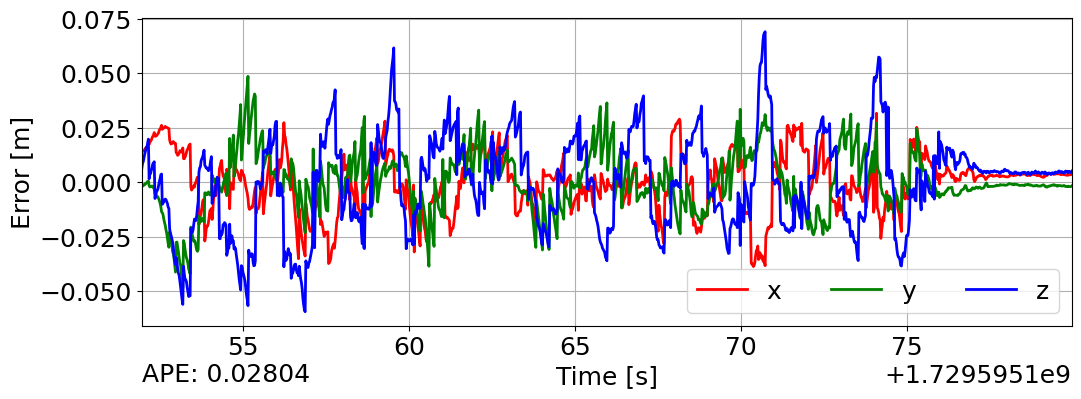

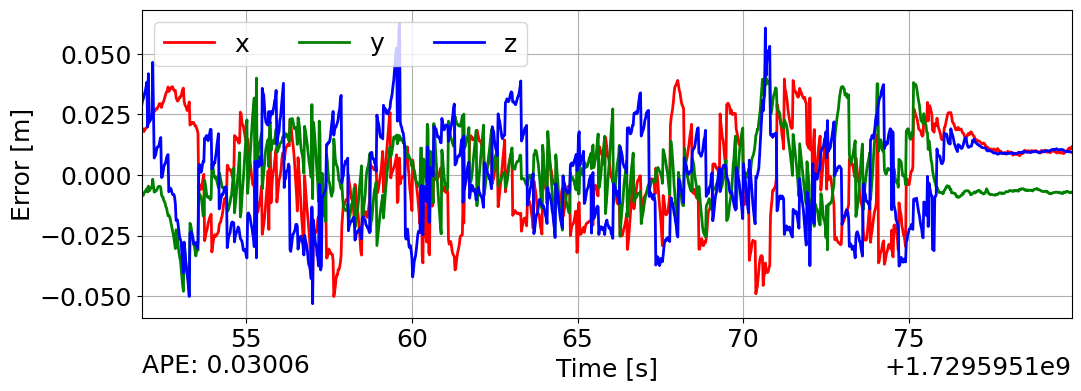

In [7]:
# Load the trajectory
traj_trajlo_data = []
for log in traj_trajlo_logs:
    traj_trajlo_data.append(np.loadtxt(log, delimiter=' ', skiprows=11))

traj_gtr_data = []
for log in traj_gtr_logs:
    traj_gtr_data.append(np.loadtxt(log, delimiter=' '))

for lidx in range(len(traj_trajlo_data)):

    # Get the traj_trajlo
    traj_trajlo = traj_trajlo_data[lidx]
    ttrajlo = (traj_trajlo[:, 0] - traj_trajlo[0, 0]).reshape(-1, 1)
    tidx = list(np.where((test_start < ttrajlo) & (ttrajlo < test_end))[0])
    traj_trajlo = evotraj.PoseTrajectory3D(positions_xyz=traj_trajlo[tidx, :][:, [1, 2, 3]], orientations_quat_wxyz=traj_trajlo[tidx, :][:, [7, 4, 5, 6]], timestamps=traj_trajlo[tidx, 0])

    # Get the traj gtr
    traj_gtr = traj_gtr_data[lidx]
    traj_gtr = evotraj.PoseTrajectory3D(positions_xyz=traj_gtr[:, 2:5], orientations_quat_wxyz=traj_gtr[:, [8, 5, 6, 7]], timestamps=traj_gtr[:, 1])

    traj_trajlo, traj_gtr = sync.associate_trajectories(traj_trajlo, traj_gtr, max_diff=0.2)
    traj_trajlo.align(traj_gtr)
    traj_err = evotraj.PoseTrajectory3D(positions_xyz=traj_trajlo.positions_xyz - traj_gtr.positions_xyz, \
                                        orientations_quat_wxyz=traj_trajlo.orientations_quat_wxyz, timestamps=traj_trajlo.timestamps)

    # Find the RMSE
    rmse = calculate_metric(traj_trajlo, traj_gtr)

    plt.rcParams.update({'font.size':18})
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 4))
    ax.plot(traj_err.timestamps, traj_err.positions_xyz[:, 0], 'r', linewidth=2, label='x')
    ax.plot(traj_err.timestamps, traj_err.positions_xyz[:, 1], 'g', linewidth=2, label='y')
    ax.plot(traj_err.timestamps, traj_err.positions_xyz[:, 2], 'b', linewidth=2, label='z')

    # Stamp the ATE
    ax.text(0, -0.18, f'APE: {rmse:.5f}', transform=ax.transAxes)

    ax.set_xlim([np.min(traj_trajlo.timestamps), np.max(traj_trajlo.timestamps-1.0)])
    # ax.set_ylim([-0.06, 0.06])
    ax.legend(ncols=3)
    ax.grid('on')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Error [m]')

